In [ ]:
# https://www.kaggle.com/datasets/mohamedchahed/dog-breeds

In [ ]:
!pip install kaggle

In [ ]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d mohamedchahed/dog-breeds

mkdir: cannot create directory ‘/root/.kaggle’: File exists
Dataset URL: https://www.kaggle.com/datasets/mohamedchahed/dog-breeds
License(s): CC0-1.0
dog-breeds.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
!unzip dog-breeds.zip

Archive:  dog-breeds.zip
  inflating: dog-breeds/beagle/beagle1.jpg  
  inflating: dog-breeds/beagle/beagle10.jpg  
  inflating: dog-breeds/beagle/beagle101.jpg  
  inflating: dog-breeds/beagle/beagle105.jpg  
  inflating: dog-breeds/beagle/beagle106.jpg  
  inflating: dog-breeds/beagle/beagle108.jpg  
  inflating: dog-breeds/beagle/beagle109.jpg  
  inflating: dog-breeds/beagle/beagle11.jpg  
  inflating: dog-breeds/beagle/beagle110.jpg  
  inflating: dog-breeds/beagle/beagle112.jpg  
  inflating: dog-breeds/beagle/beagle114.jpg  
  inflating: dog-breeds/beagle/beagle115.jpg  
  inflating: dog-breeds/beagle/beagle116.jpg  
  inflating: dog-breeds/beagle/beagle118.jpg  
  inflating: dog-breeds/beagle/beagle12.jpg  
  inflating: dog-breeds/beagle/beagle13.jpg  
  inflating: dog-breeds/beagle/beagle14.jpg  
  inflating: dog-breeds/beagle/beagle15.jpg  
  inflating: dog-breeds/beagle/beagle16.jpg  
  inflating: dog-breeds/beagle/beagle17.jpg  
  inflating: dog-breeds/beagle/beagle18.jpg  

In [ ]:
import os
import random
import shutil
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Activation, Flatten, Dropout, Dense, BatchNormalization
from tensorflow.keras.models import Sequential

from sklearn.metrics import classification_report
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import LearningRateScheduler

# Data Augmentation

In [ ]:
# Creating ImageDataGenerator instance to Augument,split and then pass our images to the model
data_gen = ImageDataGenerator(rescale = 1./255 ,
                              width_shift_range = 0.2 ,
                              validation_split=0.1,
                              height_shift_range = 0.2 ,
                              shear_range = 0.2 ,
                              horizontal_flip = True ,
                              vertical_flip = True,
                              zoom_range = 0.2)

# Applying Data Augementation On Both Training and validation sets

In [ ]:
# Creating our test and validation data generator to flow images to network from images directory

training_data = data_gen.flow_from_directory('/content/dog-breeds',
                                            target_size = (224,224),
                                            class_mode='categorical',
                                            subset = 'training'
                                            )
validation_data = data_gen.flow_from_directory('/content/dog-breeds',
                                              target_size = (224,224),
                                              class_mode='categorical',
                                              subset = 'validation')

Found 490 images belonging to 8 classes.
Found 51 images belonging to 8 classes.


# Downloading a Pretrained InceptionV3 Model by URL

In [ ]:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /content/sample_data/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5


--2024-07-05 11:57:16--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.167.207, 172.253.115.207, 172.253.122.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.167.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘/content/sample_data/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

/content/sample_dat 100%[===================>]  83.84M   146MB/s    in 0.6s    

2024-07-05 11:57:16 (146 MB/s) - ‘/content/sample_data/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]



# Transfer Learning Intialization and Configuration

In [ ]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras import layers

# Set the weights file downloaded into a variable
local_weights_file = '/content/sample_data/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'


pre_trained_model = InceptionV3(input_shape = (224, 224, 3),
                                include_top = False,
                                weights = None)

# Load the pre-trained weights downloaded.
pre_trained_model.load_weights(local_weights_file)

# Freeze the weights of the layers.
# we don't want to re-train model's convolutional layers.
for layer in pre_trained_model.layers:
    layer.trainable = False

In [ ]:
last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

last layer output shape:  (None, 12, 12, 768)


# Model Architecutre

In [ ]:
# Flatten the output layer to 1 dimension
x = layers.Flatten()(last_output)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(1024, activation='relu')(x)
# Add a dropout rate of 0.2
x = layers.Dropout(0.2)(x)                        # This Has Regularization effects
# Add a final sigmoid layer for classification
x = layers.Dense  (8, activation='softmax')(x)

# Append the dense network to the base model
model = Model(pre_trained_model.input, x)

# Print the model summary. See your dense network connected at the end.
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 111, 111, 32)         864       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 111, 111, 32)         96        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 111, 111, 32)         0         ['batch_normalization[0][0

# Model Compilation

In [ ]:
def step_decay(epoch):
    initial_alpha = 0.01
    factor = 0.5
    drop_every_epoch = 5
    alpha = initial_alpha * (factor ** np.floor((1+epoch) / drop_every_epoch))
    return float(alpha)

callbacks = [LearningRateScheduler(step_decay)]

print("[INFO] compiling model...")

opt = SGD(learning_rate=0.01,momentum=0.9, nesterov=True)

model.compile(loss='categorical_crossentropy', optimizer=opt,metrics=['accuracy'])

[INFO] compiling model...


# Model Training

In [ ]:
history = model.fit(
            training_data,
            validation_data = validation_data,
            epochs = 20,
            callbacks=callbacks,
            verbose = 1)

Epoch 1/20
16/16 [==============================] - 103s 6s/step - loss: 4.3041 - accuracy: 0.1714 - val_loss: 2.0163 - val_accuracy: 0.1569 - lr: 0.0100
Epoch 2/20
16/16 [==============================] - 98s 6s/step - loss: 1.8207 - accuracy: 0.3163 - val_loss: 1.9363 - val_accuracy: 0.2549 - lr: 0.0100
Epoch 3/20
16/16 [==============================] - 97s 6s/step - loss: 1.2963 - accuracy: 0.5510 - val_loss: 1.1175 - val_accuracy: 0.5882 - lr: 0.0100
Epoch 4/20
16/16 [==============================] - 96s 6s/step - loss: 0.7533 - accuracy: 0.7429 - val_loss: 0.9473 - val_accuracy: 0.6863 - lr: 0.0100
Epoch 5/20
16/16 [==============================] - 97s 6s/step - loss: 0.6173 - accuracy: 0.7837 - val_loss: 0.6352 - val_accuracy: 0.7647 - lr: 0.0050
Epoch 6/20
16/16 [==============================] - 98s 6s/step - loss: 0.4677 - accuracy: 0.8490 - val_loss: 0.4409 - val_accuracy: 0.8627 - lr: 0.0050
Epoch 7/20
16/16 [==============================] - 97s 6s/step - loss: 0.4599 - 

# plot the training loss and accuracy

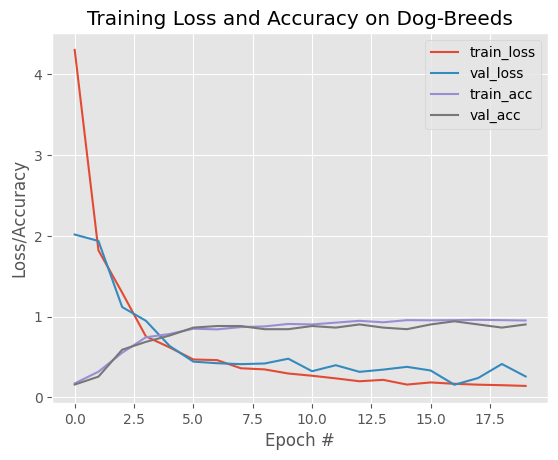

In [ ]:
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, 20), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, 20), history.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, 20), history.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, 20), history.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy on Dog-Breeds")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.show()

# Confusion Matrix

2/2 [==============================] - 7s 2s/step


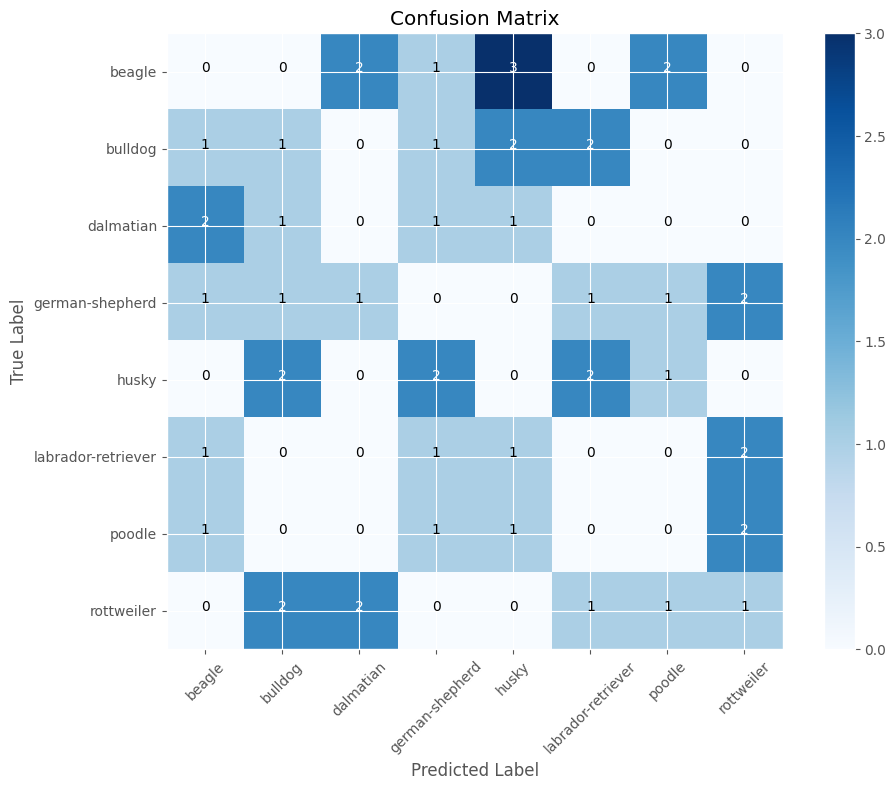

In [ ]:
# Generate predictions on the validation set
from sklearn.metrics import confusion_matrix
y_pred = model.predict(validation_data)

# Convert predictions from one-hot encoded format to class labels
y_pred_labels = np.argmax(y_pred, axis=1)

# Get true labels from the validation data generator
true_labels = validation_data.classes

conf_matrix = confusion_matrix(true_labels, y_pred_labels)

plt.figure(figsize=(10, 8))
plt.imshow(conf_matrix, cmap='Blues')

plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

tick_marks = np.arange(len(validation_data.class_indices))
plt.xticks(tick_marks, validation_data.class_indices, rotation=45)
plt.yticks(tick_marks, validation_data.class_indices)

thresh = conf_matrix.max() / 2.0
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        plt.text(j, i, format(conf_matrix[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if conf_matrix[i, j] > thresh else "black")

plt.colorbar()
plt.tight_layout()
plt.show()

# Save and Load Model

In [ ]:
from google.colab import drive
drive.mount('/content/my_drive')

Mounted at /content/my_drive


In [ ]:
model.save('/content/my_drive/MyDrive/fine_tuned_inception.h5')


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
from tensorflow.keras.models import load_model

loaded_model = load_model('/content/my_drive/MyDrive/fine_tuned_inception.h5')

# Predictive System

In [ ]:
from tensorflow.keras.preprocessing import image

def predict_and_display(model, class_labels, img_path, true_class=None):
    img = image.load_img(img_path, target_size=(224, 224))

    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = img_array / 255.0

    predictions = loaded_model.predict(img_array)
    predicted_class = np.argmax(predictions)
    confidence_level = np.max(predictions)

    predicted_class_name = class_labels[predicted_class]

    plt.imshow(img)
    plt.axis('off')

    if true_class:
        plt.title(f'Predicted Class: {predicted_class_name}, True Class: {true_class}')
    else:
        plt.title(f'Predicted Class: {predicted_class_name}')
    plt.show()

1/1 [==============================] - 1s 1s/step


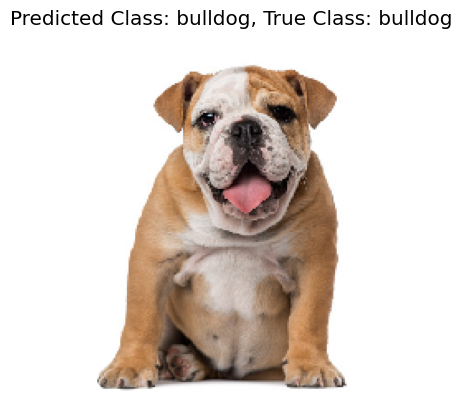

In [ ]:
class_labels = ['beagle', 'bulldog', 'dalmatian', 'german-shepherd', 'husky', 'labrador-retriever', 'poodle', 'rottweiler']
predict_and_display(model, class_labels, '/content/dog-breeds/bulldog/bulldog108.jpg', true_class='bulldog')

1/1 [==============================] - 0s 162ms/step


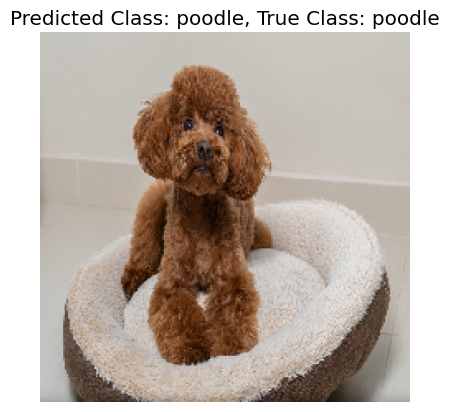

In [ ]:
predict_and_display(model, class_labels, '/content/dog-breeds/poodle/poodle116.jpg', true_class="poodle")

1/1 [==============================] - 0s 166ms/step


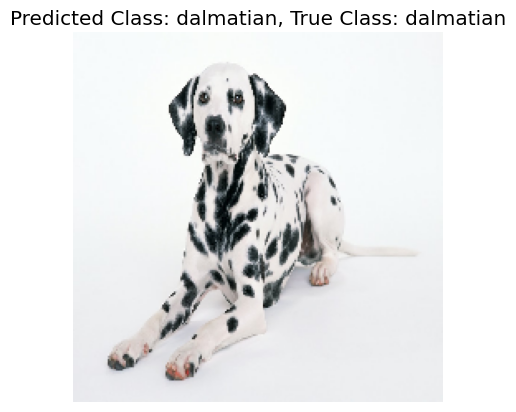

In [ ]:
predict_and_display(model, class_labels, '/content/dog-breeds/dalmatian/dalmatian20.jpg', true_class="dalmatian")